# CSCA 5622 Final Project

## Project Description

This project aims to analyze and predict the average difference between the scheduled travel time and actual travel time for each trip in the Boston Massachusetts public transit network for the year 2022.

This is achieved by combining a dataset that contains realtime performance metrics like travel times for each trip and a dataset that contains the public transit safety alerts and their severity levels.

By measuring the impact of these public safety events on the predictions, this study can be used to simulate planned network maintenance and help public transit officials communicate estimated delay times as these events occur.

### Approach:
1. **Data Cleaning and Preprocessing**: 
    - Filter and clean the performance and alert data to include only relevant records from 2022.
    - Handle missing values and convert necessary columns to appropriate data types.

2. **Feature Engineering**:
    - Create the target feature which is the average difference between the scheduled trip time and the actual trip time for each route, stop, and day grouping.
    - Generate features representing the count of alerts at different severity levels.
    - Merge the public safety and the performance datasets to create a unified data structure

3. **Data Visualization**:
    - Visualize the distribution of travel time differences and the correlation between features using histograms and heatmaps.

4. **Model Building**:
    - Implement multiple linear regression models to identify significant features affecting travel time differences.
    - Use AdaBoost regression to improve prediction accuracy and evaluate model performance using metrics like Mean Squared Error (MSE) and R-squared.

5. **Model Evaluation**:
    - Plot residuals and compare predicted values against actual values to assess model performance.

## Data
### Performance Dataset
Dataset citation: MBTA LAMP Public Data. (n.d.). https://performancedata.mbta.com/

The performance dataset contains 12 million data points that represent each time a train pulled into a station in 2022. The metadata associated with each trip is represented by the following schema:

![image1](figures/performance_data_schema.png)

However, this project is mostly interested in the `travel_time_seconds` and the `scheduled_travel_time` features which are used to create the target feature. These features represent the number of seconds that a trip took and the number of seconds that a trip was scheduled to take respectively.

### Public safety Dataset
Dataset citation: MBTA LAMP Public Data. (n.d.). https://performancedata.mbta.com/

The public safety dataset contains 400,000 data points that represent each service alert that was posted in 2022 along with the type and severity of the alert. The metadata associated with each alert is represented by the following schema:

![image2](figures/public_safety_data_schema.png)

Here we are interested in the `severity` feature and the `active_period.start_datetime` to calculate the number of safety alerts at each severity level for each day in 2022.

## Data Cleaning and Feature Engineering

### Data Cleaning Steps:
1. **Filter Performance Data**:
    - Read in the performance data files and filter them to include only records from the year 2022.
    - Convert necessary columns to appropriate data types, such as converting timestamps to datetime objects.

2. **Filter Public Safety Data**:
    - Read in the alerts data and filter it to include only alerts from the year 2022.
    - Convert necessary columns to appropriate data types, such as converting timestamps to datetime objects.

3. **Handle Missing Values**:
    - Drop rows with missing values in critical columns such as `travel_time_seconds`, `scheduled_travel_time`, `route_id`, and `stop_id` in the performance data.
    - Drop rows with missing values in critical columns such as `informed_entity.route_id`, `informed_entity.stop_id`, and `severity` in the public safety data.

### Feature Engineering Steps:
1. **Create Travel Time Difference Feature**:
    - Calculate the travel time difference for each trip by subtracting the scheduled travel time from the actual travel time.
    - Create a new feature `daily_travel_time_difference_average` which is the average travel time difference for each route, stop, and service date grouping.

2. **Filter Outliers**:
    - Filter out records where the average travel time difference is less than or equal to zero because we are only interested in predicting a positive travel time difference.
    - Further filter out records where the average travel time difference is greater than 1000 to remove extreme outliers.

3. **Create Severity Count Features**:
    - Create new features that contain the total number of alerts at each severity level (1-10) for each route, stop, and start date grouping.
    - Create a new feature `total_incidents` that contains the total count of all incidents for each route, stop, and start date grouping.

4. **Merge DataFrames**:
    - Merge the cleaned performance data and the cleaned alerts data on `route_id`, `stop_id`, and `service_date` to create a unified data structure.

5. **Convert Categorical Columns to Numerical**:
    - Convert categorical columns such as `route_id`, `parent_station`, `vehicle_label`, and `vehicle_consist` to numerical codes.

6. **Convert Datetime to Timestamp**:
    - Convert the `service_date` column to a timestamp for easier processing in the model.

In [68]:
# Read in the alerts data from the parquet file and filter it to only include alerts from 2022
import numpy as np
import pandas as pd
import datetime
alerts_df = pd.read_parquet("~/Downloads/LAMP_RT_ALERTS.parquet")
performance_df = pd.read_parquet("~/Downloads/2022_performance_data.parquet")
performance_df["move_timestamp"] = pd.to_datetime(performance_df["move_timestamp"], unit="s")
performance_df["stop_timestamp"] = pd.to_datetime(performance_df["stop_timestamp"], unit="s")
alerts_df["active_period.start_datetime"] = pd.to_datetime(alerts_df["active_period.start_datetime"])
alerts_df["active_period.end_datetime"] = pd.to_datetime(alerts_df["active_period.end_datetime"])
alerts_df = alerts_df[alerts_df["active_period.start_datetime"].dt.date > datetime.date(2022,1,1)]
alerts_df = alerts_df[alerts_df["active_period.start_datetime"].dt.date < datetime.date(2022,12,31)]

In [69]:
performance_df.dropna(subset=["travel_time_seconds", "scheduled_travel_time", "route_id", "stop_id"], inplace=True)
alerts_df.dropna(subset=["informed_entity.route_id", "informed_entity.stop_id", "severity"], inplace=True)

In [70]:
print(performance_df.info())
print(performance_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 11788554 entries, 6 to 39324
Data columns (total 27 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   stop_sequence             int16         
 1   stop_id                   object        
 2   parent_station            object        
 3   move_timestamp            datetime64[ns]
 4   stop_timestamp            datetime64[ns]
 5   travel_time_seconds       float64       
 6   dwell_time_seconds        float64       
 7   headway_trunk_seconds     float64       
 8   headway_branch_seconds    float64       
 9   service_date              int64         
 10  route_id                  object        
 11  direction_id              bool          
 12  start_time                int64         
 13  vehicle_id                object        
 14  branch_route_id           object        
 15  trunk_route_id            object        
 16  stop_count                int16         
 17  trip_id       

In [71]:
print(alerts_df.info())
print(alerts_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 335250 entries, 657678 to 1079176
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   id                                    335250 non-null  int64         
 1   cause                                 335250 non-null  object        
 2   cause_detail                          335250 non-null  object        
 3   effect                                335250 non-null  object        
 4   effect_detail                         335250 non-null  object        
 5   severity_level                        335250 non-null  object        
 6   severity                              335250 non-null  int8          
 7   alert_lifecycle                       335250 non-null  object        
 8   duration_certainty                    335250 non-null  object        
 9   header_text.translation.text          335250 non-null  obj

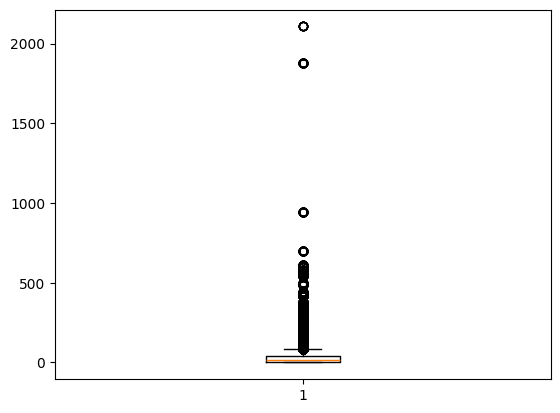

In [72]:
# Create the daily average travel time difference featrue for each route_id, stop_id, and service_date grouping
performance_df["travel_time_difference"] = performance_df["travel_time_seconds"] - performance_df["scheduled_travel_time"]
performance_df["service_date"] = pd.to_datetime(performance_df["service_date"], format="%Y%m%d")
performance_df["service_date"] = performance_df["service_date"].dt.date
performance_df["daily_travel_time_difference_average"] = performance_df.groupby(["route_id", "stop_id", "service_date"])["travel_time_difference"].transform("mean")
# We"re only interested in the times that the average travel time difference is greater than 0
performance_df = performance_df[performance_df["daily_travel_time_difference_average"] > 0]
performance_df_clean = performance_df[["daily_travel_time_difference_average", "route_id", "stop_id", "service_date", "parent_station", "vehicle_label", "vehicle_consist", "move_timestamp", "stop_timestamp"]]
import matplotlib.pyplot as plt
plt.boxplot(performance_df_clean["daily_travel_time_difference_average"])
plt.show()

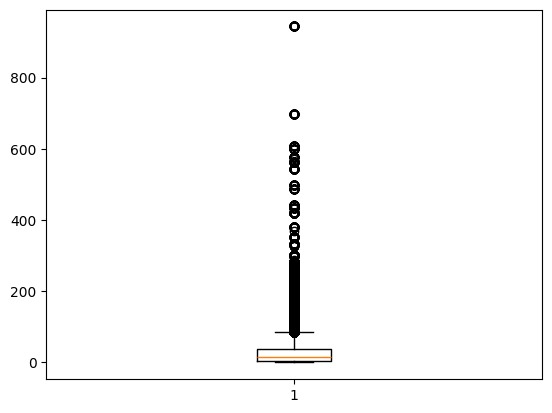

In [73]:
performance_df_clean = performance_df_clean[performance_df_clean["daily_travel_time_difference_average"] < 1000]
plt.boxplot(performance_df_clean["daily_travel_time_difference_average"])
plt.show()

In [74]:
# Create new features that contain the total number of alerts at each severity level 1-10
# and a feature that is the total count of all incidents
alerts_df["start_time"] = alerts_df["active_period.start_datetime"]
alerts_df["start_date"] = alerts_df["active_period.start_datetime"].dt.date
alerts_df["end_time"] = alerts_df["active_period.end_datetime"]
alerts_df["route_id"] = alerts_df["informed_entity.route_id"]
alerts_df["stop_id"] = alerts_df["informed_entity.stop_id"]
alerts_df_cleaned = alerts_df[["route_id", "stop_id", "severity", "start_date"]]

# Function to count the number of alerts at each severity level
def create_calculated_cols(input_df, sev):
    return np.count_nonzero(input_df == sev)

# Iterate through the severity levels 1-10 and create a new feature that contains the count of alerts at each severity level
for i in range(1,11):
    alerts_df_cleaned[f"severity_{i}_count"] = alerts_df_cleaned.groupby(["route_id", "stop_id", "start_date"])["severity"].transform(create_calculated_cols, sev=i)

# Create a new feature that contains the total number of incidents at each route_id, stop_id, and start_date grouping
alerts_df_cleaned["total_incidents"] = alerts_df_cleaned.groupby(["route_id", "stop_id", "start_date"])["severity"].transform(np.count_nonzero)
# Drop the severity column as it is no longer needed
alerts_df_cleaned.drop(["severity"], axis=1, inplace=True)

/var/folders/tw/kcv_hv8d4tvbb_g2mh146cb80000gn/T/ipykernel_38815/1167162694.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts_df_cleaned[f"severity_{i}_count"] = alerts_df_cleaned.groupby(["route_id", "stop_id", "start_date"])["severity"].transform(create_calculated_cols, sev=i)
/var/folders/tw/kcv_hv8d4tvbb_g2mh146cb80000gn/T/ipykernel_38815/1167162694.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts_df_cleaned[f"severity_{i}_count"] = alerts_df_cleaned.groupby(["route_id", "stop_id", 

In [75]:
# Merge the performance and alert data frames on route_id, stop_id, and service_date
merged_df = performance_df_clean.merge(alerts_df_cleaned, left_on=["route_id", "stop_id", "service_date"], right_on=["route_id", "stop_id", "start_date"], how="inner")
# Convert categorical columns to numerical
merged_df["route_id"] = merged_df["route_id"].astype("category").cat.codes
merged_df["parent_station"] = merged_df["parent_station"].astype("category").cat.codes
merged_df["vehicle_label"] = merged_df["vehicle_label"].astype("category").cat.codes
merged_df["vehicle_consist"] = merged_df["vehicle_consist"].astype("category").cat.codes
# Convert datetime to timestamp
merged_df["service_date"] = pd.to_datetime(merged_df["service_date"]).astype(int)
print(merged_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374466 entries, 0 to 374465
Data columns (total 21 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   daily_travel_time_difference_average  374466 non-null  float64       
 1   route_id                              374466 non-null  int8          
 2   stop_id                               374466 non-null  object        
 3   service_date                          374466 non-null  int64         
 4   parent_station                        374466 non-null  int8          
 5   vehicle_label                         374466 non-null  int16         
 6   vehicle_consist                       374466 non-null  int16         
 7   move_timestamp                        374466 non-null  datetime64[ns]
 8   stop_timestamp                        374466 non-null  datetime64[ns]
 9   start_date                            374466 non-null  obje

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374466 entries, 0 to 374465
Data columns (total 17 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   daily_travel_time_difference_average  374466 non-null  float64
 1   stop_id                               374466 non-null  object 
 2   severity_1_count                      374466 non-null  int64  
 3   parent_station                        374466 non-null  int8   
 4   vehicle_label                         374466 non-null  int16  
 5   vehicle_consist                       374466 non-null  int16  
 6   service_date                          374466 non-null  int64  
 7   severity_2_count                      374466 non-null  int64  
 8   severity_3_count                      374466 non-null  int64  
 9   severity_4_count                      374466 non-null  int64  
 10  severity_5_count                      374466 non-null  int64  
 11  

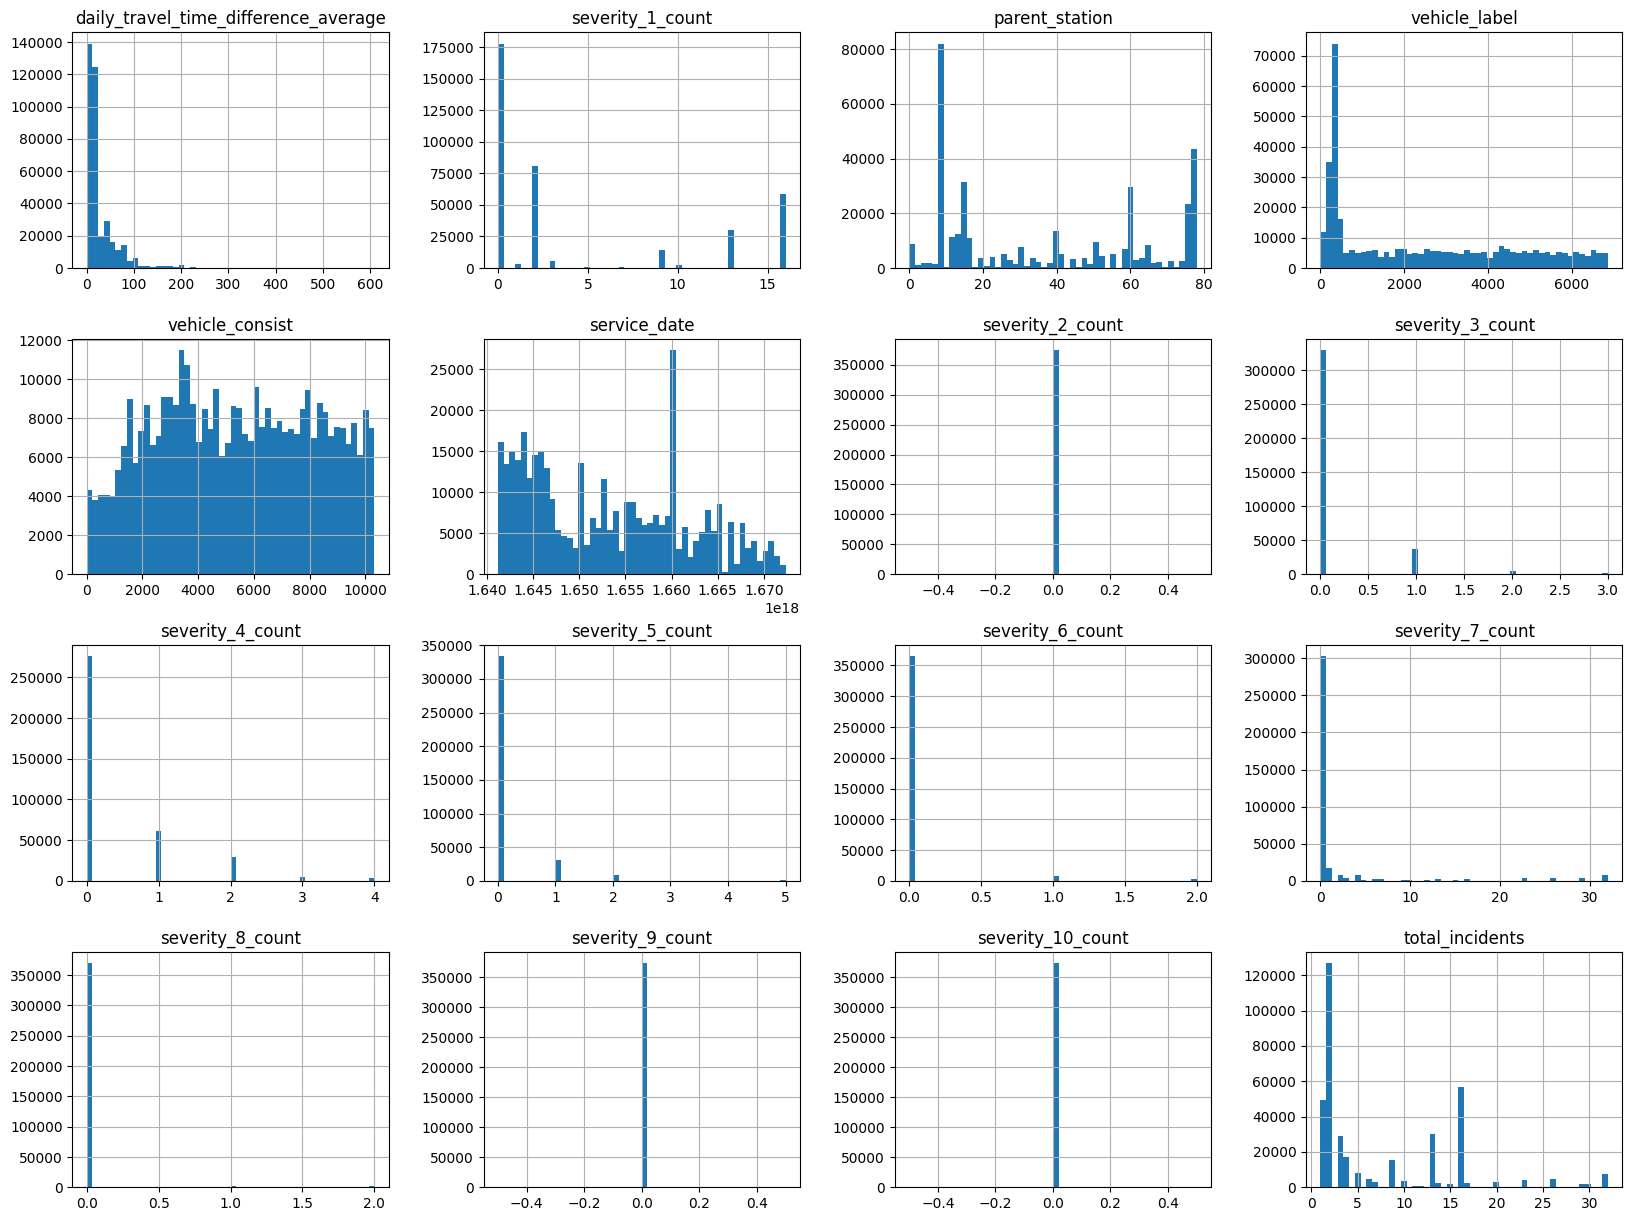

<Axes: >

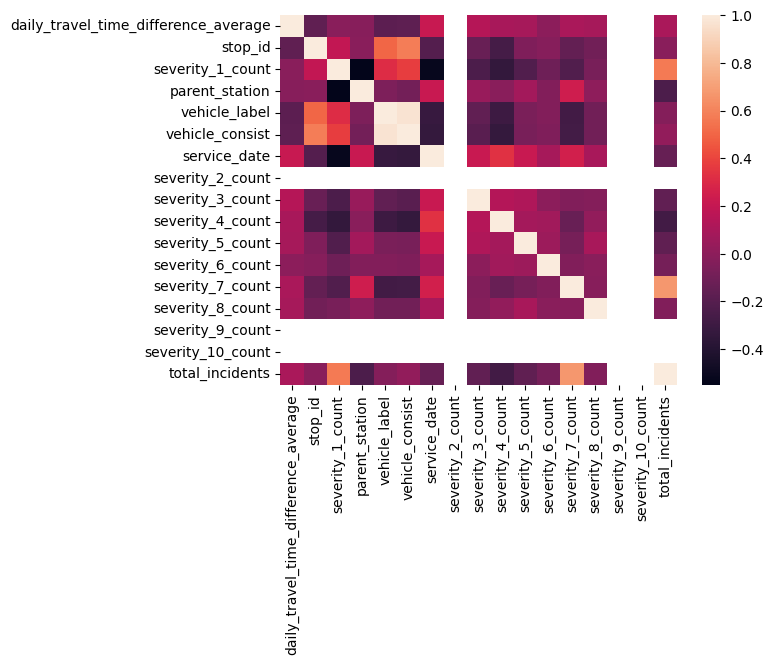

In [76]:
import seaborn as sns
# Select the features to be used in the model
merged_df = merged_df[["daily_travel_time_difference_average", "stop_id", "severity_1_count", "parent_station",
                       "vehicle_label", "vehicle_consist", "service_date",
                       "severity_2_count", "severity_3_count", "severity_4_count",
                       "severity_5_count", "severity_6_count", "severity_7_count",
                       "severity_8_count", "severity_9_count", "severity_10_count", "total_incidents"]]
print(merged_df.info())
print(merged_df.head())
import matplotlib.pyplot as plt
merged_df.hist(bins=50, figsize=(20,15))
plt.show()
# Create the correlation matrix for the features
sns.heatmap(merged_df.corr())

### Exporatory data analysis

#### Correlation Matrix
- The `severity_3_count`, `severity_4_count`, `total_incidents` and `severity_8_count` features show a positive correlation with the `daily_travel_time_difference_average`, suggesting that higher counts of these severity levels are associated with greater travel time differences.

- Features `severity_2_count`, `severity_9_count`, and `severity_10_count` are empty so those features will be removed in the subsequent step

- There are multiple features that are correlated with each other (Ex: `stop_id` and `vehicle_consist`) so these features will have to be removed for the basic linear regression model

#### Histogram
- The `daily_travel_time_difference_average` histogram shows a right-skewed distribution, indicating that most travel time differences are relatively small, but there are still some larger outliers.

- The `severity_1_count` and `severity_2_count` histograms show that these severity levels are relatively common, while higher severity levels (e.g., `severity_8_count`, `severity_9_count`, `severity_10_count`) are less frequent.

- The `total_incidents` histogram shows that most days have a low number of incidents, but there are some days with a higher number of incidents.

The data suggests that some of the severity level counts and the total number of incidents may have an impact on the travel time differences.

In [77]:
from sklearn.model_selection import train_test_split
# remove the features that don"t have any data
# and split the data into training and testing sets
x = merged_df.drop(["severity_2_count", "severity_9_count", "severity_10_count"], axis=1)
y = x["daily_travel_time_difference_average"]
x_train, x_test, y_train, y_test = train_test_split(x, y)

## Model 1: Simple Multi Linear Regression

### Approach
To build a multi linear regression model, first I removed some of the features that were highly correlated with each other. Then, I iteratively build a linear regression model over 5 steps to select the feature that maximizes the model's r^2 value. To assess the model performance, I note the r^2 value for the final model and observe the distribution of the residuals for the test data set.

In [78]:
#Try a multiple linear regression model step wise
import statsmodels.formula.api as smf
x_train_simple_regression = x_train.drop(["stop_id", "parent_station", "vehicle_label", "vehicle_consist", "service_date", "total_incidents"], axis=1)
best = ["",0]
# Model with step = 1
for p in set(x.columns)-{"daily_travel_time_difference_average", "stop_id", "parent_station", "vehicle_label", "vehicle_consist", "service_date", "total_incidents"}:
    model  = smf.ols(formula="daily_travel_time_difference_average~"+p, data=x_train_simple_regression).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print("best:",best)
print(model.summary())

severity_1_count 0.00020413791636575418
severity_8_count 0.007679228456402121
severity_7_count 0.010308994993404319
severity_5_count 0.007952529298153932
severity_3_count 0.021540542500196214
severity_6_count 3.820995870817967e-07
severity_4_count 0.00885404637104048
best: ['severity_3_count', np.float64(0.021540542500196214)]
                                     OLS Regression Results                                     
Dep. Variable:     daily_travel_time_difference_average   R-squared:                       0.009
Model:                                              OLS   Adj. R-squared:                  0.009
Method:                                   Least Squares   F-statistic:                     2509.
Date:                                  Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                                          21:10:03   Log-Likelihood:            -1.4094e+06
No. Observations:                                280849   AIC:                         2.

In [79]:
import statsmodels.formula.api as smf
best = ["",0]
# Model with step = 2
for p in set(x.columns)-{"daily_travel_time_difference_average", "severity_3_count", "stop_id", "parent_station", "vehicle_label", "vehicle_consist", "service_date", "total_incidents"}:
    model  = smf.ols(formula="daily_travel_time_difference_average~severity_3_count+"+p, data=x_train_simple_regression).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print("best:",best)

severity_1_count 0.02199773868667587
severity_8_count 0.030125136023935628
severity_7_count 0.03321081213728627
severity_5_count 0.026772150213183576
severity_6_count 0.0215409677643581
severity_4_count 0.02717631659390285
best: ['severity_7_count', np.float64(0.03321081213728627)]


In [80]:
import statsmodels.formula.api as smf
best = ["",0]
# Model with step = 3
for p in set(x.columns)-{"daily_travel_time_difference_average", "severity_3_count", "severity_7_count", 
                         "stop_id", "parent_station", "vehicle_label", "vehicle_consist", "service_date", "total_incidents"}:
    model  = smf.ols(formula="daily_travel_time_difference_average~severity_3_count+severity_7_count+"+p, data=x_train_simple_regression).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print("best:",best)

severity_1_count 0.035547533468473946
severity_8_count 0.04219673322300699
severity_5_count 0.03967824731607794
severity_6_count 0.03323671950775009
severity_4_count 0.04130842458673112
best: ['severity_8_count', np.float64(0.04219673322300699)]


In [81]:
import statsmodels.formula.api as smf
best = ["",0]
# Model with step = 4
for p in set(x.columns)-{"daily_travel_time_difference_average", "severity_3_count", "severity_7_count", "severity_8_count", 
                         "stop_id", "parent_station", "vehicle_label", "vehicle_consist", "service_date", "total_incidents"}:
    model  = smf.ols(formula="daily_travel_time_difference_average~severity_3_count+severity_5_count+severity_8_count+"+p, data=x_train_simple_regression).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print("best:",best)
final_model = smf.ols(formula=f"daily_travel_time_difference_average~severity_3_count+severity_5_count+severity_8_count+{best[0]}", data=x_train_simple_regression).fit()

severity_6_count 0.03406938415562155
severity_5_count 0.03406762538630459
severity_1_count 0.035820609077419685
severity_4_count 0.038803235703347316
best: ['severity_4_count', np.float64(0.038803235703347316)]


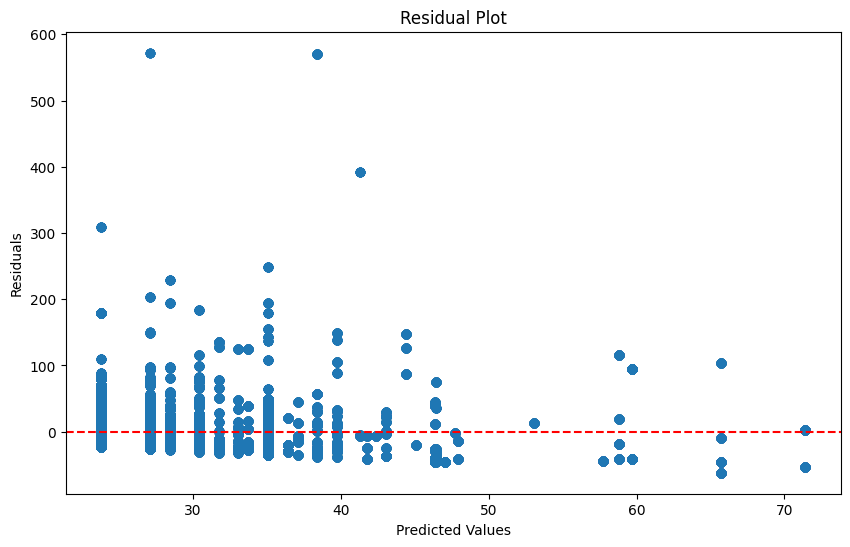

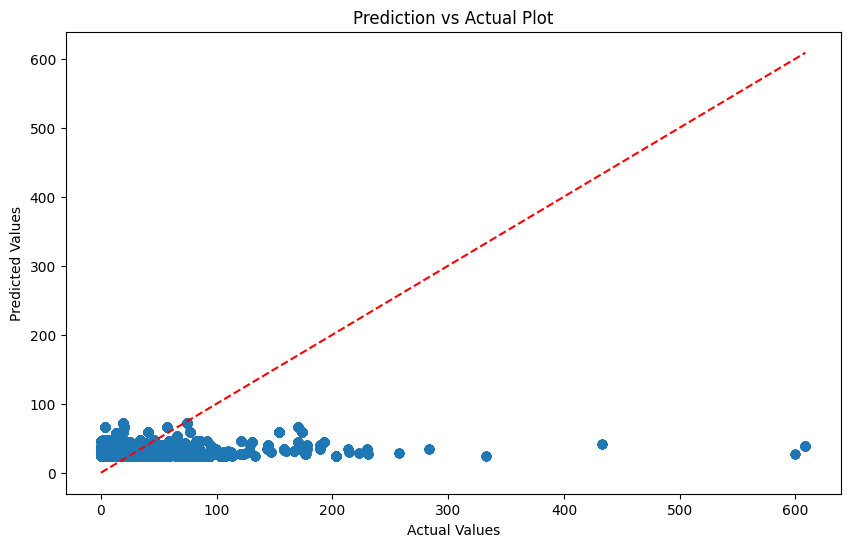

In [82]:
# Plot the residuals
import matplotlib.pyplot as plt
y_pred = final_model.predict(x_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()
# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Plot')
plt.show()

## Multi Linear regression model conclusions
The final model resulted in an r^2 value of 0.0383 which very low and can not be considered significant. Furthermore, by examining plots of the residuals and the predicted vs actual time difference average, we can see that the model does not perform well. We would expect the points on each plot to reside on the dotted line but they diverge significantly. 

With these findings I conclude that a multi linear regression model is not a good fit for this task.

## Model 2: AdaBoost Regressor

### Approach
I choose to implement an AdaBoost regressor due to the non-parametric nature of the model and the ability for the model to overcome issues with interactions between many features. To build the AdaBoost model, I first run a grid search on a selection of hyperparameters in order to create an optimized model. I then use these hyperparameters to build a model and evaluate the model on the test dataset using MSE and r^2 values as well as an analysis on the residuals.

In [65]:
# Try an AdaBoost model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
x_train_adaboost = x_train.drop(["daily_travel_time_difference_average"], axis=1)
x_test_adaboost = x_test.drop(["daily_travel_time_difference_average"], axis=1)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10]
}
model = AdaBoostRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=6)
grid_search.fit(x_train_adaboost, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


/Users/joeburke/Projects/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.01, 'n_estimators': 200}


In [66]:
# best_params = {'learning_rate': 0.01, 'n_estimators': 200}
final_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=best_params["n_estimators"], learning_rate=best_params["learning_rate"])
final_model.fit(x_train_adaboost, y_train)
print(f"Features: {x_train_adaboost.columns}")
print(f"Feature importances: {final_model.feature_importances_}")

# Predict and evaluate
y_pred = final_model.predict(x_train_adaboost)
mse = mean_squared_error(y_train, y_pred)
r_2 = r2_score(y_train, y_pred)
print(f"Mean Squared Error for training data: {mse}")
print(f"r^2 score for training data: {r_2}")
y_pred = final_model.predict(x_test_adaboost)
mse = mean_squared_error(y_test, y_pred)
r_2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error for testing data: {mse}")
print(f"r^2 score for testing data: {r_2}")

Features: Index(['stop_id', 'severity_1_count', 'parent_station', 'vehicle_label',
       'vehicle_consist', 'service_date', 'severity_3_count',
       'severity_4_count', 'severity_5_count', 'severity_6_count',
       'severity_7_count', 'severity_8_count', 'total_incidents'],
      dtype='object')
Feature importances: [0.38675454 0.03903711 0.08193042 0.00263434 0.00339707 0.26927753
 0.0235754  0.00884487 0.01428141 0.01108472 0.0749106  0.00303467
 0.08123733]
Mean Squared Error for training data: 0.019574182670824215
r^2 score for training data: 0.9999856058617892
Mean Squared Error for testing data: 0.3971895213794
r^2 score for testing data: 0.9997138009417018


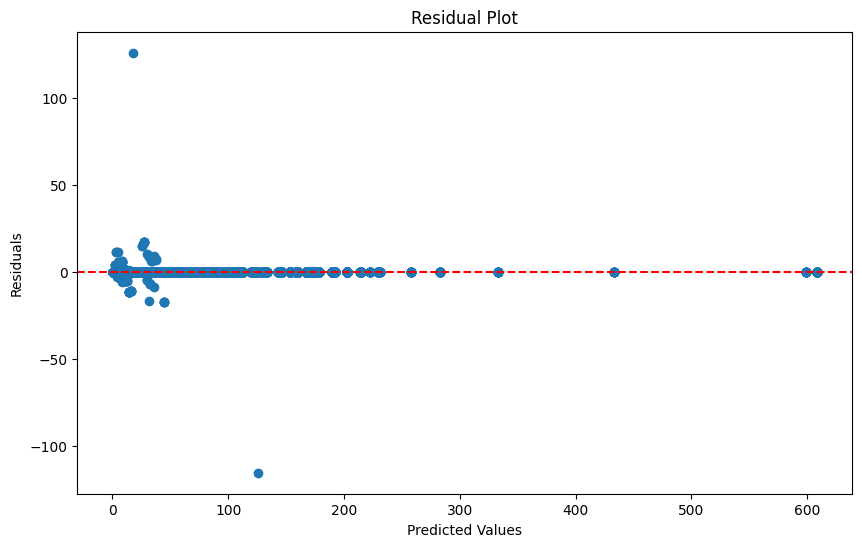

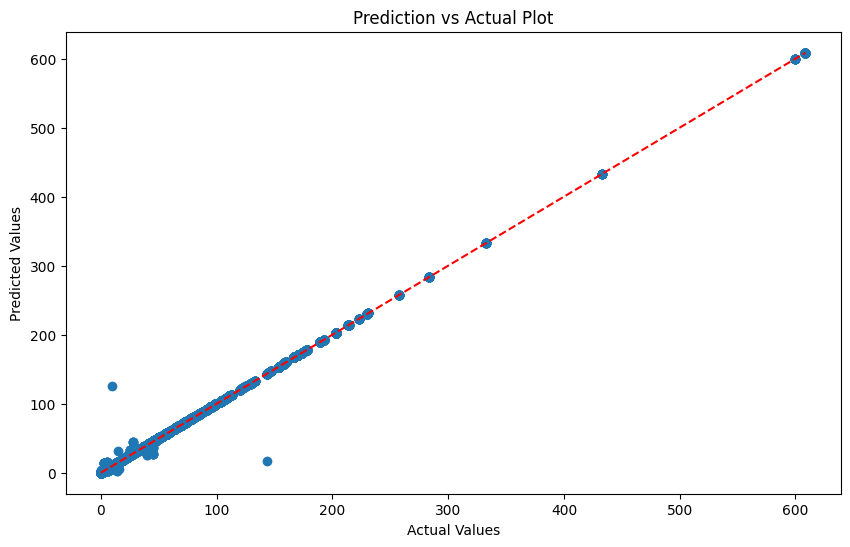

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the residuals for the testing data
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
# Prediction vs Actual Plot for the testing data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Plot')
plt.show()

## AdaBoost model Conclusions
The final model resulted in an r^2 value of 0.999 which is very high and can be considered significant. Also, the final model gave an MSE score of 0.397 which can be considered decent. Since the MSE is calculated based of the residuals, and the residuals of the model are pretty small I would expect a smaller MSE for a more accurate model.

By looking at the plots of the residuals and the predicted vs actual values we can see that the AdaBoost model is much better at the regression task compared to the multi linear regression model. For example, the predicted vs actual values plot has the majority of the points sitting on the trendline whereas the multi linear regression model had much fewer points on the trend line.

Based on these results, I would say that the AdaBoost regressor created here could be a decent model for predicting the average difference between the actual trip time and the scheduled trip time.

## Discussion and Conclusion

### Learnings and Takeaways

The goal of this project was to analyze and predict the average difference between the scheduled travel time and actual travel time for each trip in the Boston Massachusetts public transit network for the year 2022. 
This was achieved by combining a dataset containing real-time performance metrics with a dataset containing public transit safety alerts and their severity levels.

I have learned here that the impact of the public safety alerts was not as significant as I thought going into this project. As someone who rides the MBTA almost everyday, I feel the impact of these events on a personal level and am surprised that they don't have more of an impact throughout the network.

I have also learned the power of non parametric models, such as AdaBoost, to create a decent model on noisy and sparse data. The model that I ended up creating was not perfect but is a significant improvement compared to more basic methods.

### Limitations

One of the main limitations for this project was not being able to use all of the historical data that is made available by the MBTA due to time constraints. Before filtering out the merged dataset by only looking at the positive values for the target feature, the model took hours to train and the AdaBoost GridSearch did not complete after a day. In a perfect world I would recreate this project using all of the available data and run the training on a more powerful machine. 

Another limitation of this project is that the target value is a calculated average. I wanted to create a dataset that merged the performance data for each train stop with the public safety alerts that were active at that specific timestamp but due to the size of the data this was not feasible.

### Next Steps
To build off of this project, I would propose the following next steps:
- Aggregate a larger dataset based on all historical data
- Test out other non parametric models such as KNN and SVMs
- Build a more robust grid search technique for further optimizing the hyperparameters for the AdaBoost model

## Conclusion

The results of this project indicate that the AdaBoost regressor is a more suitable model for predicting the average difference between the actual travel time and scheduled travel time in the Boston public transit network. The high r^2 value and low MSE demonstrate the model's ability to accurately capture the relationship between the features and the target variable.

The findings suggest that certain severity levels of safety alerts have an impact on travel time differences, but not as large of an impact as you might think. This information can still be valuable for public transit officials in planning and communicating estimated delay times during public safety events.
